**Library Imports**

In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import itertools
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from torchinfo import summary
import itertools
import ipywidgets as widgets
from IPython.display import display

# Dataset Loading and Preprocessing <br>
This preprocessing pipeline prepares time-series data for both LSTM and Temporal Convolutional Network (TCN) models using historical stock prices and macroeconomic indicators:
1. Data Import
2. Feature Selection and scaling
3. Sequence generation for 30 day moving windows for each stock.
4. 80-20 Train-Test Data Spltting
5. Creation of data loaders for models

In [26]:
# --- Parameters ---
file_path = "sp500_stocks_with_macro_clean.csv"
sequence_length = 30
train_ratio = 0.8
batch_size = 16

# --- Load & Sort Dataset ---
df = pd.read_csv(file_path, parse_dates=["Date"])
df = df.sort_values(by=["Symbol", "Date"]).reset_index(drop=True)

# --- Feature Selection ---
features = [
    "Adj Close", "Close", "High", "Low", "Open", "Volume", "UNRATE(%)", 
    "CONSUMER CONF INDEX", "PPI-CONST MAT.", "CPIALLITEMS", "INFLATION(%)", 
    "MORTGAGE INT. MONTHLY AVG(%)", "MED HOUSEHOLD INCOME", "CORP. BOND YIELD(%)", 
    "MONTHLY HOME SUPPLY", "% SHARE OF WORKING POPULATION", "GDP PER CAPITA", 
    "QUARTERLY REAL GDP", "QUARTERLY GDP GROWTH RATE (%)", "CSUSHPISA"
]

# --- Scaling Features ---
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# --- Symbol Indexing (for TCN) ---
stock_symbols = sorted(df["Symbol"].unique())
symbol_to_idx = {symbol: idx for idx, symbol in enumerate(stock_symbols)}

# --- Sequence Generator Functions ---
def create_lstm_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length][0])  # Predict "Adj Close"
    return np.array(X), np.array(y)

def create_tcn_sequences(data, seq_length, stock_idx):
    X, y, s = [], [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length][0])
        s.append(stock_idx)
    return np.array(X), np.array(y), np.array(s)

# --- Sequence Construction ---
lstm_sequences = {}
tcn_sequences = {}

for symbol in stock_symbols:
    stock_data = df[df["Symbol"] == symbol][features].values
    stock_idx = symbol_to_idx[symbol]

    X_lstm, y_lstm = create_lstm_sequences(stock_data, sequence_length)
    X_tcn, y_tcn, s_tcn = create_tcn_sequences(stock_data, sequence_length, stock_idx)

    lstm_sequences[symbol] = (X_lstm, y_lstm)
    tcn_sequences[symbol] = (X_tcn, y_tcn, s_tcn)

# --- DataLoader Creation ---
def create_lstm_loaders(sequences, train_ratio=0.8):
    train_loaders, test_loaders = {}, {}
    for symbol, (X, y) in sequences.items():
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32)
        
        split = int(len(X) * train_ratio)
        train_ds = TensorDataset(X_tensor[:split], y_tensor[:split])
        test_ds = TensorDataset(X_tensor[split:], y_tensor[split:])
        
        train_loaders[symbol] = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        test_loaders[symbol] = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    
    return train_loaders, test_loaders

def create_tcn_loaders(sequences, train_ratio=0.8):
    train_loaders, test_loaders = {}, {}
    for symbol, (X, y, s) in sequences.items():
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32)
        s_tensor = torch.tensor(s, dtype=torch.long)

        split = int(len(X) * train_ratio)
        train_ds = TensorDataset(X_tensor[:split], y_tensor[:split], s_tensor[:split])
        test_ds = TensorDataset(X_tensor[split:], y_tensor[split:], s_tensor[split:])
        
        train_loaders[symbol] = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        test_loaders[symbol] = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    
    return train_loaders, test_loaders

# --- Generate LSTM Loaders ---
lstm_train_loaders, lstm_test_loaders = create_lstm_loaders(lstm_sequences)

# --- Generate TCN Loaders + Combined Global Loader ---
tcn_train_loaders, tcn_test_loaders = create_tcn_loaders(tcn_sequences)

def combine_loaders(loaders_dict, shuffle=True):
    all_X, all_y, all_s = [], [], []
    for loader in loaders_dict.values():
        for X_batch, y_batch, s_batch in loader:
            all_X.append(X_batch)
            all_y.append(y_batch)
            all_s.append(s_batch)
    X_all = torch.cat(all_X, dim=0)
    y_all = torch.cat(all_y, dim=0)
    s_all = torch.cat(all_s, dim=0)
    
    dataset = TensorDataset(X_all, y_all, s_all)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

combined_train_loader = combine_loaders(tcn_train_loaders)
combined_test_loader = combine_loaders(tcn_test_loaders, shuffle=False)

# Shape Outputs
print("Total Stocks:", len(stock_symbols))
print("LSTM Train/Test Example (First Stock):")
first_sym = stock_symbols[0]
print("  Symbol:", first_sym)
print("  Train Sequences:", len(lstm_train_loaders[first_sym].dataset))
print("  Test Sequences :", len(lstm_test_loaders[first_sym].dataset))

print("\nTCN Train/Test Example (First Stock):")
print("  Symbol:", first_sym)
print("  Train Sequences:", len(tcn_train_loaders[first_sym].dataset))
print("  Test Sequences :", len(tcn_test_loaders[first_sym].dataset))

# Check global loader sizes for TCN
combined_train_batch = next(iter(combined_train_loader))
print("\nCombined TCN Loader Batch Sizes:")
print("  X_batch:", combined_train_batch[0].shape)
print("  y_batch:", combined_train_batch[1].shape)
print("  stock_index_batch:", combined_train_batch[2].shape)

Total Stocks: 23
LSTM Train/Test Example (First Stock):
  Symbol: ANET
  Train Sequences: 1568
  Test Sequences : 392

TCN Train/Test Example (First Stock):
  Symbol: ANET
  Train Sequences: 1568
  Test Sequences : 392

Combined TCN Loader Batch Sizes:
  X_batch: torch.Size([16, 30, 20])
  y_batch: torch.Size([16])
  stock_index_batch: torch.Size([16])


**Device Config**

In [27]:
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use Apple Metal (MPS)
elif torch.cuda.is_available():
    device = torch.device("cuda")  # Use NVIDIA GPU
else:
    device = torch.device("cpu")  # Default to CPU
print(f"Using device: {device}")

Using device: mps


# Model Architecture <br>
This section defines the architectures used in both the LSTM and TCN models. Descriptions of each step in the modeling are included below.
1. LSTM Model Definition
2. Residual Dilated Convolution Block (used for TCN)
3. TCN Model Definition
4. Summaries of models using default parameters

In [28]:
class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=100, num_layers=1, output_size=1):
        super(StockLSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Step 1: Define Dropout Rate
        # Dropout is only applied if there are multiple LSTM layers
        # Reason: Helps prevent overfitting in deeper networks
        lstm_dropout = 0.0 if num_layers == 1 else 0.3

        # Step 2: Define LSTM Layer
        # Input Shape: [batch_size, seq_len, input_size]
        # Output Shape: [batch_size, seq_len, hidden_size]
        # Reason: Captures temporal dependencies using memory cells
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=lstm_dropout
        )

        # Step 3: Define Fully Connected Output Layer
        # Input Shape: [batch_size, hidden_size]
        # Output Shape: [batch_size, output_size]
        # Reason: Maps final LSTM output to the prediction (e.g., next-day price)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Step 4: Initialize Hidden and Cell States
        # Shape: [num_layers, batch_size, hidden_size]
        # Reason: LSTM needs initial hidden state (h0) and cell state (c0)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Step 5: Pass Through LSTM Layer
        # Output: all hidden states (for all time steps), and final (h_n, c_n)
        # Reason: Generates sequential hidden states capturing past dependencies
        out, _ = self.lstm(x, (h0, c0))  # out: [batch_size, seq_len, hidden_size]

        # Step 6: Select Last Time Step
        # Input Shape: [batch_size, seq_len, hidden_size]
        # Output Shape: [batch_size, hidden_size]
        # Reason: Use the last time step's hidden state to make prediction
        out = out[:, -1, :]

        # Step 7: Output Prediction
        # Input Shape: [batch_size, hidden_size]
        # Output Shape: [batch_size]
        # Reason: Final predicted value for next day
        return self.fc(out)

class ResidualBlock1D(nn.Module):
    # Input Shape (1st Convolution Layer): [batch_size, embedding_dim + feature_length, seq_len]
    # Input Shape (Other Layers): [batch_size, hidden_channels, seq_len]
    # Residual Shape: [batch_size, hidden_channels, seq_len]
    # Output Shape: [batch_size, hidden_channels, seq_len]
    # -- Steps for Convolution Layer --
    # Step 1: Calculate Padding
        # Reason: Dilated convolutions reduce the receptive field at the start of the sequence.
        #         Padding on the left restores the sequence length so that output = input in time dimension.

    # Step 2: Apply 1D Convolution
        # Reason: Extracts temporal features from the sequence using dilated filters,
        #         allowing the model to capture both short-term and long-term dependencies.

    # Step 3: ReLU Activation Function
        # Reason: Introduces non-linearity, allowing the model to learn more complex representations.

    # Step 4: Dropout Layer
        # Reason: Randomly zeroes out parts of the layer to prevent overfitting and improve generalization.

    # Step 5: Residual Connection
        # Reason: Adds the original input (or a projection of it) to the output, helping with gradient flow
        #         and enabling deeper networks to train more effectively.
    
    def __init__(self, in_channels, out_channels, kernel_size, dilation, dropout):
        super().__init__()
        self.padding = (kernel_size - 1) * dilation

        self.conv = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            dilation=dilation,
            padding=0  # manual padding 
        )
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        self.residual_proj = (
            nn.Conv1d(in_channels, out_channels, kernel_size=1)
            if in_channels != out_channels else nn.Identity()
        )

    def forward(self, x):
        residual = self.residual_proj(x)
        x_padded = nn.functional.pad(x, (self.padding, 0))  # pad left side only
        out = self.conv(x_padded)
        out = self.relu(out)
        out = self.dropout(out)
        return out + residual


class StockEmbeddedTCNN(nn.Module):
    def __init__(self, input_channels, num_stocks, embedding_dim=8, hidden_channels=64, kernel_size=3, dropout=0.2, num_layers=3):
        super().__init__()
        self.stock_embedding = nn.Embedding(num_stocks, embedding_dim)
        combined_input_channels = input_channels + embedding_dim

        layers = []
        for i in range(num_layers):
            dilation = 2 ** i
            in_channels = combined_input_channels if i == 0 else hidden_channels
            block = ResidualBlock1D(
                in_channels=in_channels,
                out_channels=hidden_channels,
                kernel_size=kernel_size,
                dilation=dilation,
                dropout=dropout
            )
            layers.append(block)
        self.network = nn.Sequential(*layers)
        self.fc = nn.Linear(hidden_channels, 1)

    def forward(self, x, stock_idx):
        # Step 1: Stock Embedding
        # Input: stock_idx (Tensor of stock IDs), Shape: [batch_size]
        # Output: Embedded vector per stock, Shape: [batch_size, embedding_dim]
        # Reason: Encodes stock identity using learned embeddings, allowing the model to differentiate between stocks based on historical patterns
        emb = self.stock_embedding(stock_idx)

        # Step 2: Expanded Embedding Layer
        # Input: Embedded Vector, Shape [batch_size, embedding_dim]
        # Output: Expanded Embedded Vector, Shape [batch_size, seq_len, embedding_dim]
        # Reason: Applies the embedding information to all parts of the sequence 
        emb = emb.unsqueeze(1).expand(-1, x.size(1), -1)
        
        # Step 3: Concatenate Features and Embedding
        # Input: Features, Expanded Embedded Vector, Shape: [feature_length], [batch_size, seq_len, embedding_dim]
        # Output: Features with Embeddings, Shape: [batch_size, seq_len, embedding_dim + feature_length]
        # Reason: Combines embedding information with feature information
        x = torch.cat([x, emb], dim=2)

        # Step 4: Permutation Layer
        # Input Shape: [batch_size, seq_len, embedding_dim + feature_length]
        # Output Shape: [batch_size, embedding_dim + feature_length, seq_len]
        # Reason: Changes the order of the vector to be consistent with 1D Conv Layer shape
        x = x.permute(0, 2, 1)

        # Step 5: Pass Through Residual Dilated Conv Network
        # Input Shape: [batch_size, embedding_dim + feature_length, seq_len]
        # Output Shape: [batch_size, hidden_channels, seq_len]
        # Reason: This is all of the convolution steps (see above for more information)
        x = self.network(x)

        # Step 6: Select Final Time Step
        # Input Shape: [batch_size, hidden_channels, seq_len]
        # Output Shape: [batch_size, hidden_channels]
        # Reason: Only use the last information from the processed sequence to make predictions
        x = x[:, :, -1]

        # Step 7: Make Predictions
        # Input Shape: [batch_size, hidden_channels]
        # Output Shape: [batch_size]
        # Reason: Final Next Day Prediction (The last squeeze on there is just to ensure final ouput isnt [batch_size, 1])
        return self.fc(x).squeeze(-1)

# Some Default Params to produce a model summary
input_size = 20
sequence_length = 30
batch_size = 16
num_stocks = 23

lstm_test_model = StockLSTM(input_size=input_size).to(device)
print(summary(
    lstm_test_model, 
    input_size=(batch_size, sequence_length, input_size), 
    col_names=["input_size", "output_size", "num_params"], 
    col_width=20,
    device=device
))

tcn_model = StockEmbeddedTCNN(input_channels=input_size, num_stocks=num_stocks).to(device)
print(summary(
    tcn_model, 
    input_data=[
        torch.zeros(batch_size, sequence_length, input_size).to(device),
        torch.zeros(batch_size, dtype=torch.long).to(device)
    ],
    col_names=["input_size", "output_size", "num_params"], 
    col_width=20,
    device=device
))

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #
StockLSTM                                [16, 30, 20]         [16, 1]              --
├─LSTM: 1-1                              [16, 30, 20]         [16, 30, 100]        48,800
├─Linear: 1-2                            [16, 100]            [16, 1]              101
Total params: 48,901
Trainable params: 48,901
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 23.43
Input size (MB): 0.04
Forward/backward pass size (MB): 0.38
Params size (MB): 0.20
Estimated Total Size (MB): 0.62
Layer (type:depth-idx)                   Input Shape          Output Shape         Param #
StockEmbeddedTCNN                        [16, 30, 20]         [16]                 --
├─Embedding: 1-1                         [16]                 [16, 8]              184
├─Sequential: 1-2                        [16, 28, 30]         [16, 64, 30]         --
│    └─ResidualBlock1D: 2-1              [16, 28, 30]         [16, 64,

# Training Loops
This section contains the training functions for both the LSTM and TCN models, each of which implements early stopping based on validation loss to prevent overfitting. During training, metrics such as loss, RMSE, MAPE, and R² are tracked across epochs for both the training and validation sets. A plotting function is also provided to visualize training progress by comparing loss and RMSE trends over time for each model.

In [12]:
def train_lstm_model(model, train_loaders, test_loaders, lr=0.001, num_epochs=200, patience=5):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adagrad(model.parameters(), lr=lr)

    best_model_state = None
    min_val_loss = float("inf")
    patience_counter = 0
    train_loss_hist, val_loss_hist = [], []
    train_rmse_history, val_rmse_history = [], []
    best_metrics = {}

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_train_loss = 0.0
        train_actuals, train_preds = [], []

        for loader in train_loaders.values():
            for X_batch, y_batch in loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device).view(-1, 1)

                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()

                train_preds.extend(outputs.cpu().detach().numpy())
                train_actuals.extend(y_batch.cpu().detach().numpy())

        avg_train_loss = total_train_loss / len(train_loaders)
        train_loss_hist.append(avg_train_loss)

        # Calculate training RMSE
        train_rmse = np.sqrt(mean_squared_error(train_actuals, train_preds))
        train_rmse_history.append(train_rmse)

        # Validation
        model.eval()
        val_actuals, val_preds = [], []

        with torch.no_grad():
            for loader in test_loaders.values():
                for X_batch, y_batch in loader:
                    X_batch = X_batch.to(device)
                    y_batch = y_batch.to(device)
                    outputs = model(X_batch).squeeze(-1)

                    val_preds.extend(outputs.cpu().numpy())
                    val_actuals.extend(y_batch.cpu().numpy())

        val_loss = np.mean((np.array(val_actuals) - np.array(val_preds)) ** 2)
        val_loss_hist.append(val_loss)

        val_rmse = np.sqrt(mean_squared_error(val_actuals, val_preds))
        val_rmse_history.append(val_rmse)

        mape = mean_absolute_percentage_error(val_actuals, val_preds)
        r2 = r2_score(val_actuals, val_preds)

        print(f"Epoch {epoch:03} | Train Loss: {avg_train_loss:.6f} | Val Loss: {val_loss:.6f} | "
              f"Train RMSE: {train_rmse:.6f} | Val RMSE: {val_rmse:.6f} | MAPE: {mape:.6f} | R²: {r2:.6f}")

        if val_loss < min_val_loss:
            min_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
            best_metrics = {
                "train_rmse": train_rmse,
                "val_rmse": val_rmse,
                "mape": mape,
                "r2": r2,
                "best_val_loss": val_loss,
                "epochs_trained": epoch
            }
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(best_model_state)
    return model, train_loss_hist, val_loss_hist, train_rmse_history, val_rmse_history, best_metrics



def train_tcn_model(model, train_loader, test_loader, lr=0.001, num_epochs=200, patience=5):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adagrad(model.parameters(), lr=lr)

    best_model_state = None
    min_val_loss = float("inf")
    patience_counter = 0
    train_loss_hist, val_loss_hist = [], []
    train_rmse_history, val_rmse_history = [], []
    best_metrics = {}

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_train_loss = 0.0
        train_preds, train_actuals = [], []

        for X_batch, y_batch, s_batch in train_loader:
            X_batch, y_batch, s_batch = X_batch.to(device), y_batch.to(device), s_batch.to(device)

            optimizer.zero_grad()
            preds = model(X_batch, s_batch)
            loss = criterion(preds.view(-1, 1), y_batch.view(-1, 1))
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            train_preds.extend(preds.cpu().detach().numpy())
            train_actuals.extend(y_batch.cpu().detach().numpy())

        avg_train_loss = total_train_loss / len(train_loader)
        train_loss_hist.append(avg_train_loss)

        # Calculate training RMSE
        train_rmse = np.sqrt(mean_squared_error(train_actuals, train_preds))
        train_rmse_history.append(train_rmse)

        # Validation
        model.eval()
        val_preds, val_actuals = [], []

        with torch.no_grad():
            for X_batch, y_batch, s_batch in test_loader:
                X_batch, y_batch, s_batch = X_batch.to(device), y_batch.to(device), s_batch.to(device)
                outputs = model(X_batch, s_batch)
                val_preds.extend(outputs.cpu().numpy())
                val_actuals.extend(y_batch.cpu().numpy())

        val_loss = np.mean((np.array(val_actuals) - np.array(val_preds)) ** 2)
        val_loss_hist.append(val_loss)

        val_rmse = np.sqrt(mean_squared_error(val_actuals, val_preds))
        val_rmse_history.append(val_rmse)

        mape = mean_absolute_percentage_error(val_actuals, val_preds)
        r2 = r2_score(val_actuals, val_preds)

        print(f"Epoch {epoch:03} | Train Loss: {avg_train_loss:.6f} | Val Loss: {val_loss:.6f} | "
              f"Train RMSE: {train_rmse:.6f} | Val RMSE: {val_rmse:.6f} | MAPE: {mape:.6f} | R²: {r2:.6f}")

        if val_loss < min_val_loss:
            min_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
            best_metrics = {
                "train_rmse": train_rmse,
                "val_rmse": val_rmse,
                "mape": mape,
                "r2": r2,
                "best_val_loss": val_loss,
                "epochs_trained": epoch
            }
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(best_model_state)
    return model, train_loss_hist, val_loss_hist, train_rmse_history, val_rmse_history, best_metrics


# Plot Function for Baseline Models
def plot_loss_and_rmse_curves(
    lstm_train, lstm_val, lstm_train_rmse, lstm_val_rmse,
    tcn_train, tcn_val, tcn_train_rmse, tcn_val_rmse,
    lstm_patience=5,
    tcn_patience=5
):
    epochs_lstm = list(range(1, len(lstm_train) + 1))
    epochs_tcn = list(range(1, len(tcn_train) + 1))

    # Early stopping reference points
    lstm_early_stop = len(epochs_lstm) - lstm_patience
    tcn_early_stop = len(epochs_tcn) - tcn_patience

    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    # --- LSTM Loss ---
    axs[0, 0].plot(epochs_lstm, lstm_train, label="Train Loss", marker='o')
    axs[0, 0].plot(epochs_lstm, lstm_val, label="Val Loss", marker='x')
    axs[0, 0].axvline(x=lstm_early_stop, color='red', linestyle='--', label='Early Stopping')
    axs[0, 0].set_yscale('log')  # Log scaling
    axs[0, 0].set_title("LSTM Loss Curve (Log Scale)")
    axs[0, 0].set_xlabel("Epoch")
    axs[0, 0].set_ylabel("MSE Loss (Log)")
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # --- LSTM RMSE ---
    axs[1, 0].plot(epochs_lstm, lstm_train_rmse, label="Train RMSE", marker='o')
    axs[1, 0].plot(epochs_lstm, lstm_val_rmse, label="Val RMSE", marker='x')
    axs[1, 0].axvline(x=lstm_early_stop, color='red', linestyle='--', label='Early Stopping')
    axs[1, 0].set_title("LSTM RMSE (Accuracy)")
    axs[1, 0].set_xlabel("Epoch")
    axs[1, 0].set_ylabel("RMSE")
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # --- TCN Loss ---
    axs[0, 1].plot(epochs_tcn, tcn_train, label="Train Loss", marker='o')
    axs[0, 1].plot(epochs_tcn, tcn_val, label="Val Loss", marker='x')
    axs[0, 1].axvline(x=tcn_early_stop, color='red', linestyle='--', label='Early Stopping')
    axs[0, 1].set_yscale('log')  # Log scaling
    axs[0, 1].set_title("TCN Loss Curve (Log Scale)")
    axs[0, 1].set_xlabel("Epoch")
    axs[0, 1].set_ylabel("MSE Loss (Log)")
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # --- TCN RMSE ---
    axs[1, 1].plot(epochs_tcn, tcn_train_rmse, label="Train RMSE", marker='o')
    axs[1, 1].plot(epochs_tcn, tcn_val_rmse, label="Val RMSE", marker='x')
    axs[1, 1].axvline(x=tcn_early_stop, color='red', linestyle='--', label='Early Stopping')
    axs[1, 1].set_title("TCN RMSE (Accuracy)")
    axs[1, 1].set_xlabel("Epoch")
    axs[1, 1].set_ylabel("RMSE")
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    plt.tight_layout()
    plt.show()



# Baseline Model Performance
Baseline models using default parameters are conducted to ensure model feasibility. Plots are generated to check for model performance on RMSE and loss functions to examine overfitting and the early stopping mechanism.

In [10]:
# Baseline Models
# === Train One LSTM Model (Baseline) ===
lstm_model = StockLSTM(input_size=20).to(device)
lstm_model, lstm_train_loss, lstm_val_loss, lstm_train_rmse, lstm_rmse_history, lstm_metrics = train_lstm_model(
    model=lstm_model,
    train_loaders=lstm_train_loaders,
    test_loaders=lstm_test_loaders,
)

# === Train One TCN Model (Baseline) ===
tcn_model = StockEmbeddedTCNN(
    input_channels=20,
    num_stocks=23,
).to(device)

tcn_model, tcn_train_loss, tcn_val_loss, tcn_train_rmse, tcn_rmse_history, tcn_metrics = train_tcn_model(
    model=tcn_model,
    train_loader=combined_train_loader,
    test_loader=combined_test_loader,
)

Epoch 001 | Train Loss: 0.035276 | Val Loss: 0.002735 | Train RMSE: 0.016147 | Val RMSE: 0.052295 | MAPE: 0.312503 | R²: 0.939690
Epoch 002 | Train Loss: 0.006249 | Val Loss: 0.001288 | Train RMSE: 0.006794 | Val RMSE: 0.035885 | MAPE: 0.199988 | R²: 0.971603
Epoch 003 | Train Loss: 0.004419 | Val Loss: 0.000593 | Train RMSE: 0.005712 | Val RMSE: 0.024343 | MAPE: 0.150152 | R²: 0.986932
Epoch 004 | Train Loss: 0.003724 | Val Loss: 0.000376 | Train RMSE: 0.005242 | Val RMSE: 0.019395 | MAPE: 0.130396 | R²: 0.991705
Epoch 005 | Train Loss: 0.003396 | Val Loss: 0.000296 | Train RMSE: 0.005005 | Val RMSE: 0.017200 | MAPE: 0.113908 | R²: 0.993476
Epoch 006 | Train Loss: 0.003209 | Val Loss: 0.000267 | Train RMSE: 0.004867 | Val RMSE: 0.016351 | MAPE: 0.099711 | R²: 0.994104
Epoch 007 | Train Loss: 0.003094 | Val Loss: 0.000260 | Train RMSE: 0.004777 | Val RMSE: 0.016133 | MAPE: 0.094016 | R²: 0.994260
Epoch 008 | Train Loss: 0.003003 | Val Loss: 0.000266 | Train RMSE: 0.004706 | Val RMSE: 0

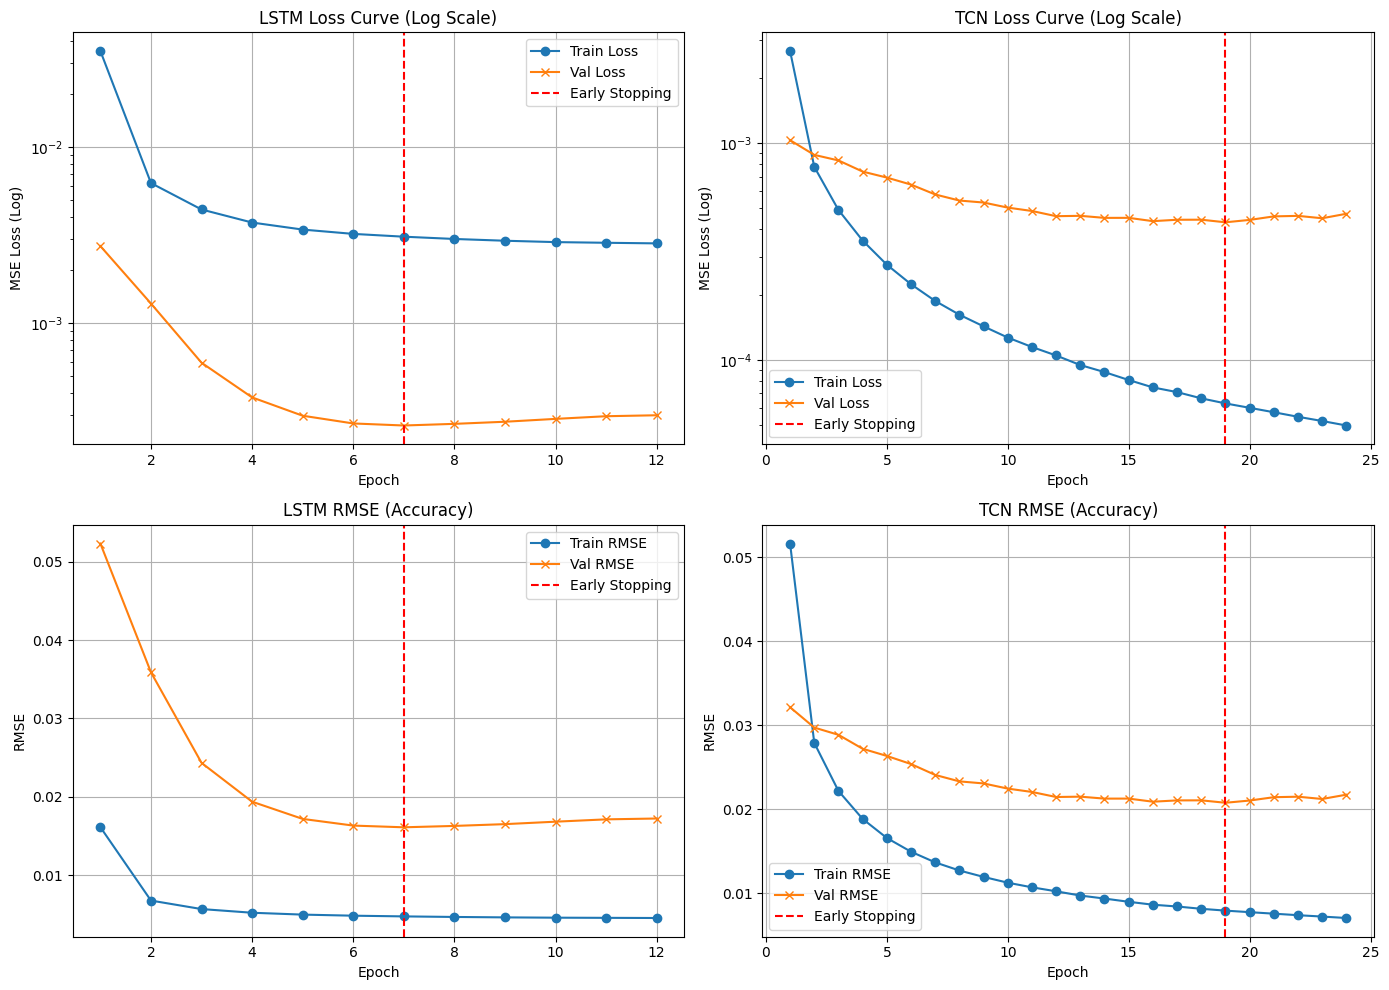

In [13]:
plot_loss_and_rmse_curves(
    lstm_train=lstm_train_loss, 
    lstm_val=lstm_val_loss, 
    lstm_train_rmse=lstm_train_rmse, 
    lstm_val_rmse=lstm_rmse_history,
    tcn_train=tcn_train_loss, 
    tcn_val=tcn_val_loss, 
    tcn_train_rmse=tcn_train_rmse, 
    tcn_val_rmse=tcn_rmse_history,
)

# Hyperparameter Tuning
A grid search is conducted using relevant hyperparameters:
- LSTM: Hidden size of each LSTM Layer, number of LSTM layers, and learning rate
- TCN: Kernel Size, number of residual dilated blocks, and size of 1D convolution layer (assume best learning rate from previous LSTM search)

Following the grid search, heatmaps are created to showcase performance (focused on RMSE but other metrics have similar trends).

In [8]:
os.makedirs("saved_models_final", exist_ok=True)
lstm_results = []

# Grid Search Hyperparameters
hidden_sizes = [50, 100, 150, 200]
num_layers_list = [1, 2]
learning_rates = [0.01, 0.005, 0.001]

for hidden_size, num_layers, lr in itertools.product(hidden_sizes, num_layers_list, learning_rates):
    print(f"\n LSTM | hidden_size={hidden_size}, num_layers={num_layers}, lr={lr}")

    model = StockLSTM(input_size=20, hidden_size=hidden_size, num_layers=num_layers).to(device)
    model, train_loss, val_loss, rmse_history, best_metrics = train_lstm_model(
        model=model,
        train_loaders=lstm_train_loaders,
        test_loaders=lstm_test_loaders,
        lr=lr,
        num_epochs=200,
        patience=5
    )

    # Save model
    model_filename = f"lstm_h{hidden_size}_l{num_layers}_lr{lr}.pt"
    model_path = os.path.join("saved_models_final", model_filename)
    torch.save(model.state_dict(), model_path)

    # Log results
    lstm_results.append({
        "hidden_size": hidden_size,
        "num_layers": num_layers,
        "learning_rate": lr,
        **best_metrics,
        "model_file": model_filename
    })

# Save to CSV
lstm_df = pd.DataFrame(lstm_results)
lstm_df.to_csv("lstm_grid_search_results.csv", index=False)
print("\n LSTM Grid Search Complete — Results saved to lstm_grid_search_results.csv")



tcn_results = []

# TCN Hyperparameter Grid
kernel_sizes = [2, 3, 4]
hidden_channels_list = [32, 64, 128]
num_layers_list = [2, 3, 4]

for kernel_size, hidden_channels, num_layers in itertools.product(kernel_sizes, hidden_channels_list, num_layers_list):
    print(f"\n TCN | kernel_size={kernel_size}, hidden_channels={hidden_channels}, num_layers={num_layers}")

    model = StockEmbeddedTCNN(
        input_channels=20,
        num_stocks=23,
        embedding_dim=8,
        hidden_channels=hidden_channels,
        kernel_size=kernel_size,
        num_layers=num_layers,
        dropout=0.2
    ).to(device)

    model, train_loss, val_loss, rmse_history, best_metrics = train_tcn_model(
        model=model,
        train_loader=combined_train_loader,
        test_loader=combined_test_loader,
        lr=0.001,
        num_epochs=200,
        patience=5
    )

    # Save model
    model_filename = f"tcn_k{kernel_size}_h{hidden_channels}_l{num_layers}.pt"
    model_path = os.path.join("saved_models_final", model_filename)
    torch.save(model.state_dict(), model_path)

    # Log results
    tcn_results.append({
        "kernel_size": kernel_size,
        "hidden_channels": hidden_channels,
        "num_layers": num_layers,
        **best_metrics,
        "model_file": model_filename
    })

# Save to CSV
tcn_df = pd.DataFrame(tcn_results)
tcn_df.to_csv("tcn_grid_search_results.csv", index=False)
print("\n TCN Grid Search Complete — Results saved to tcn_grid_search_results.csv")



 LSTM | hidden_size=50, num_layers=1, lr=0.01
Epoch 001 | Train Loss: 0.018653 | Val Loss: 0.001045 | RMSE: 0.032321 | MAPE: 0.144167 | R²: 0.976963
Epoch 002 | Train Loss: 0.002927 | Val Loss: 0.001082 | RMSE: 0.032896 | MAPE: 0.148359 | R²: 0.976136
Epoch 003 | Train Loss: 0.002346 | Val Loss: 0.001116 | RMSE: 0.033401 | MAPE: 0.119312 | R²: 0.975397
Epoch 004 | Train Loss: 0.002188 | Val Loss: 0.001107 | RMSE: 0.033269 | MAPE: 0.123586 | R²: 0.975591
Epoch 005 | Train Loss: 0.002070 | Val Loss: 0.001022 | RMSE: 0.031975 | MAPE: 0.124843 | R²: 0.977454
Epoch 006 | Train Loss: 0.002013 | Val Loss: 0.000987 | RMSE: 0.031420 | MAPE: 0.122976 | R²: 0.978230
Epoch 007 | Train Loss: 0.001910 | Val Loss: 0.001020 | RMSE: 0.031932 | MAPE: 0.103868 | R²: 0.977515
Epoch 008 | Train Loss: 0.001890 | Val Loss: 0.000961 | RMSE: 0.030994 | MAPE: 0.107573 | R²: 0.978816
Epoch 009 | Train Loss: 0.001848 | Val Loss: 0.000926 | RMSE: 0.030428 | MAPE: 0.109453 | R²: 0.979582
Epoch 010 | Train Loss: 0.

Best LSTM Config:
hidden_size                                                          50
num_layers                                                            1
learning_rate                                                     0.001
rmse                                                            0.01462
mape                                                           0.074388
r2                                                             0.995287
model_file                                       lstm_h50_l1_lr0.001.pt
train_loss_history    [0.13675034813980386, 0.021803481395043334, 0....
val_loss_history      [0.0040436275, 0.0011192354, 0.0010265601, 0.0...
best_val_loss                                                  0.000214
epochs_trained                                                      200
Name: 2, dtype: object


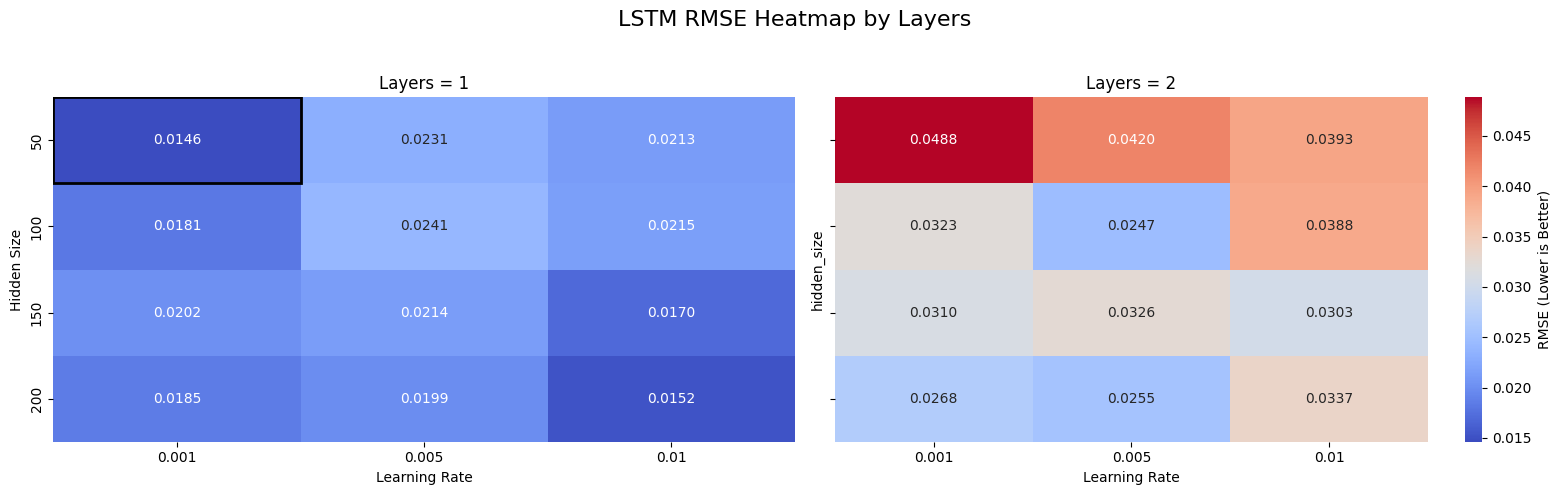

Best TCN Config:
kernel_size                                                           2
hidden_channels                                                      32
num_layers                                                            3
rmse                                                           0.012306
mape                                                           0.053484
r2                                                              0.99666
model_file                                           model_k2_h32_l3.pt
train_loss_history    [0.01213014948910246, 0.003905947851687161, 0....
val_loss_history      [0.007104080197256066, 0.0046498018712120455, ...
best_val_loss                                                  0.000151
epochs_trained                                                      200
Name: 1, dtype: object


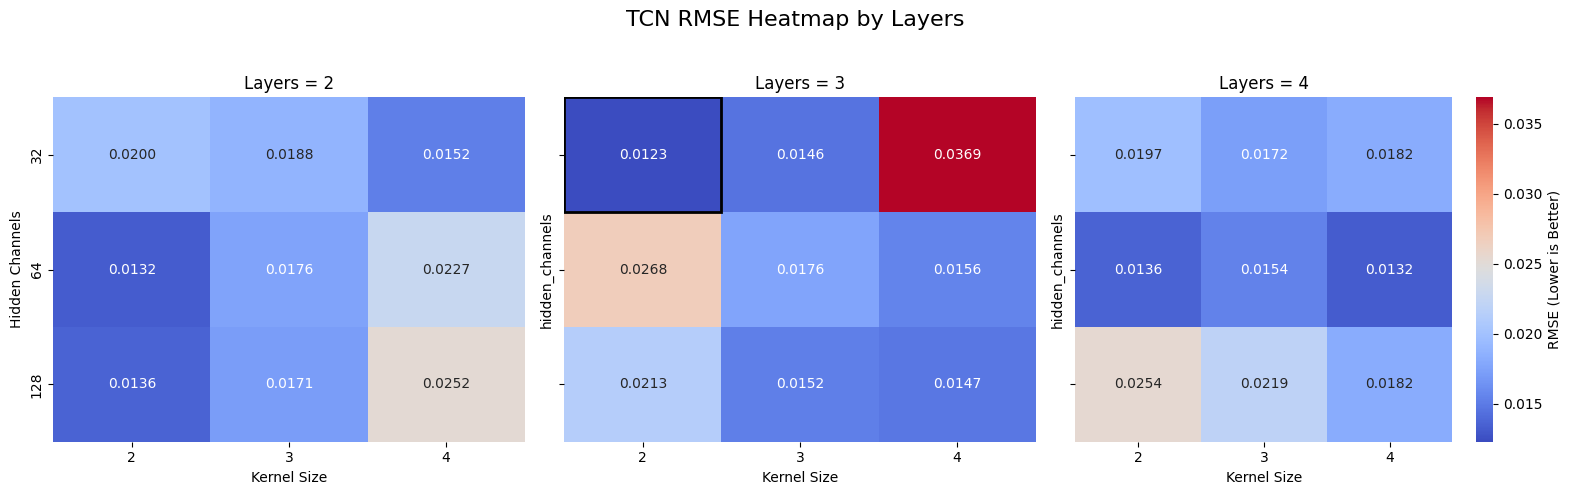

In [6]:
def plot_lstm_heatmaps(csv_path="lstm_grid_search_results.csv"):
    df = pd.read_csv(csv_path)
    unique_layers = sorted(df['num_layers'].unique())

    fig, axes = plt.subplots(1, len(unique_layers), figsize=(16, 5), sharey=True)

    vmin = df['rmse'].min()
    vmax = df['rmse'].max()

    best_row = df.loc[df['mape'].idxmin()]
    print("Best LSTM Config:")
    print(best_row)

    best_lr = best_row["learning_rate"]
    best_hidden = best_row["hidden_size"]
    best_layer = best_row["num_layers"]

    for ax, layer in zip(axes, unique_layers):
        layer_data = df[df['num_layers'] == layer].pivot_table(
            values='rmse',
            index='hidden_size',
            columns='learning_rate',
            aggfunc='mean'
        )

        sns.heatmap(
            layer_data,
            ax=ax,
            annot=True,
            fmt=".4f",
            cmap="coolwarm",
            vmin=vmin,
            vmax=vmax,
            cbar=ax == axes[-1],
            cbar_kws={'label': 'RMSE (Lower is Better)'}
        )

        if layer == best_layer:
            col_idx = list(layer_data.columns).index(best_lr)
            row_idx = list(layer_data.index).index(best_hidden)
            ax.add_patch(plt.Rectangle((col_idx, row_idx), 1, 1, fill=False, edgecolor='black', lw=2))

        ax.set_title(f'Layers = {layer}')
        ax.set_xlabel('Learning Rate')
        if ax == axes[0]:
            ax.set_ylabel('Hidden Size')

    plt.suptitle("LSTM RMSE Heatmap by Layers", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig("LSTM_Tuning.png")
    plt.show()
plot_lstm_heatmaps()

def plot_tcn_heatmaps(csv_path="tcn_grid_search_results.csv"):
    df = pd.read_csv(csv_path)
    unique_layers = sorted(df['num_layers'].unique())

    fig, axes = plt.subplots(1, len(unique_layers), figsize=(16, 5), sharey=True)

    vmin = df['rmse'].min()
    vmax = df['rmse'].max()

    best_row = df.loc[df['mape'].idxmin()]
    print("Best TCN Config:")
    print(best_row)

    best_kernel = best_row["kernel_size"]
    best_hidden = best_row["hidden_channels"]
    best_layer = best_row["num_layers"]

    for ax, layer in zip(axes, unique_layers):
        layer_data = df[df['num_layers'] == layer].pivot_table(
            values='rmse',
            index='hidden_channels',
            columns='kernel_size',
            aggfunc='mean'
        )

        sns.heatmap(
            layer_data,
            ax=ax,
            annot=True,
            fmt=".4f",
            cmap="coolwarm",
            vmin=vmin,
            vmax=vmax,
            cbar=ax == axes[-1],
            cbar_kws={'label': 'RMSE (Lower is Better)'}
        )

        if layer == best_layer:
            col_idx = list(layer_data.columns).index(best_kernel)
            row_idx = list(layer_data.index).index(best_hidden)
            ax.add_patch(plt.Rectangle((col_idx, row_idx), 1, 1, fill=False, edgecolor='black', lw=2))

        ax.set_title(f'Layers = {layer}')
        ax.set_xlabel('Kernel Size')
        if ax == axes[0]:
            ax.set_ylabel('Hidden Channels')

    plt.suptitle("TCN RMSE Heatmap by Layers", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig("TCN_Tuning.png")
    plt.show()
plot_tcn_heatmaps()

# Interactive Stock Plot

In [29]:
# --- Define Model Architectures with Final Parameters ---
lstm_model = StockLSTM(input_size=20, hidden_size=50).to(device)
tcn_model = StockEmbeddedTCNN(
    input_channels=20,
    num_stocks=len(stock_symbols),  # dynamically match number of stocks
    kernel_size=2,
    num_layers=3,
    hidden_channels=32
).to(device)

# --- Load Trained Weights ---
lstm_model.load_state_dict(torch.load("best_model_weights_LSTM.pt", map_location=device))
tcn_model.load_state_dict(torch.load("best_model_weights_TCN.pt", map_location=device))

# --- Set Models to Evaluation Mode ---
lstm_model.eval()
tcn_model.eval()


def plot_model_prediction(symbol):
    # === Get LSTM predictions ===
    lstm_loader = lstm_test_loaders[symbol]
    lstm_preds, lstm_true = [], []

    with torch.no_grad():
        for x_batch, y_batch in lstm_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            preds = lstm_model(x_batch)
            lstm_preds.extend(preds.cpu().numpy())
            lstm_true.extend(y_batch.cpu().numpy())

    # === Get TCN predictions ===
    tcn_loader = tcn_test_loaders[symbol]
    tcn_preds, tcn_true = [], []

    with torch.no_grad():
        for x_batch, y_batch, s_batch in tcn_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            s_batch = s_batch.to(device)
            preds = tcn_model(x_batch, s_batch)
            tcn_preds.extend(preds.cpu().numpy())
            tcn_true.extend(y_batch.cpu().numpy())

    # === Convert to NumPy arrays ===
    lstm_preds, lstm_true = np.array(lstm_preds), np.array(lstm_true)
    tcn_preds, tcn_true = np.array(tcn_preds), np.array(tcn_true)

    # === Metrics ===
    lstm_rmse = np.sqrt(mean_squared_error(lstm_true, lstm_preds))
    tcn_rmse = np.sqrt(mean_squared_error(tcn_true, tcn_preds))

    lstm_r2 = r2_score(lstm_true, lstm_preds)
    tcn_r2 = r2_score(tcn_true, tcn_preds)

    lstm_mape = mean_absolute_percentage_error(lstm_true, lstm_preds)
    tcn_mape = mean_absolute_percentage_error(tcn_true, tcn_preds)

    # === Plot ===
    plt.figure(figsize=(10, 5))
    plt.plot(lstm_true, label="True", linewidth=2, color="black")
    plt.plot(lstm_preds, label=f"LSTM (RMSE={lstm_rmse:.4f}, R²={lstm_r2:.4f}, MAPE={lstm_mape:.4f})",color='red', linestyle="--")
    plt.plot(tcn_preds, label=f"TCN (RMSE={tcn_rmse:.4f}, R²={tcn_r2:.4f}, MAPE={tcn_mape:.4f})",color='blue', linestyle=":")
    plt.title(f"Predictions vs True for {symbol}")
    plt.xlabel("Time Step")
    plt.ylabel("Normalized Adj Close Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [30]:
symbol_dropdown = widgets.Dropdown(
    options=stock_symbols,
    value=stock_symbols[0],
    description='Symbol:',
)

widgets.interact(plot_model_prediction, symbol=symbol_dropdown);

interactive(children=(Dropdown(description='Symbol:', options=('ANET', 'ANSS', 'APH', 'CRM', 'CSCO', 'DELL', '…